In [140]:
import torch
import torch.nn as nn
import torch.optim as optim
from PIL import Image
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import torchvision.models as models

In [141]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

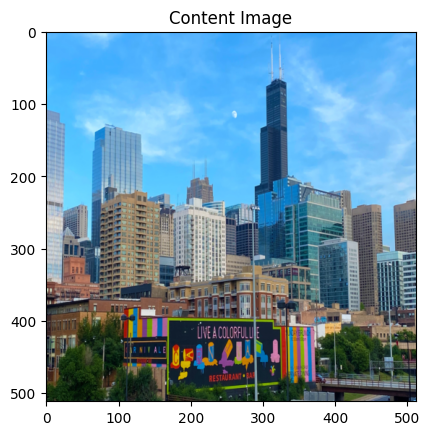

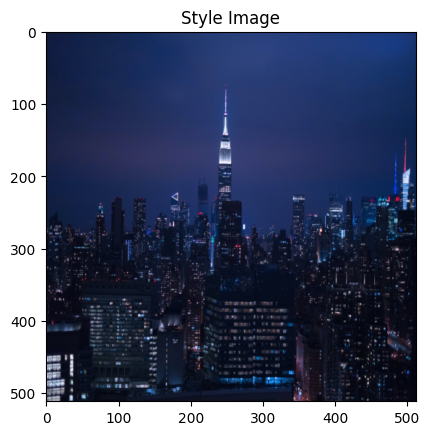

In [142]:
def load_image(path, transform) :
    image = Image.open(path)
    image = transform(image).unsqueeze(0)
    return image.to(device, torch.float)

toPIL = transforms.ToPILImage()
def display_image(tensor) :
    tensor = tensor.cpu().clone()
    tensor = tensor.squeeze(0)
    image = toPIL(tensor)
    plt.imshow(image)

transform = transforms.Compose([
            transforms.Resize((512, 512)),
            transforms.ToTensor(),
            ])

content_image = load_image("../data/day/test/jennifer-griffin-QE0WfnzziK4-unsplash.jpg", transform)
style_image = load_image("../data/night/test/jonathan-roger-fPaCAQKkRqY-unsplash.jpg", transform)

plt.figure()
display_image(content_image)
plt.title("Content Image")
plt.show()

plt.figure()
display_image(style_image)
plt.title("Style Image")
plt.show()

In [143]:
class ContentLoss(nn.Module):
    def __init__(self, target_features):
        super(ContentLoss, self).__init__()
        self.target_features = target_features.detach()

    def forward(self, input):
        self.loss = torch.mean((input - self.target_features)**2)
        return input

class StyleLoss(nn.Module):
    def __init__(self, target_features):
        super(StyleLoss, self).__init__()
        _, channels, height, width = target_features.size()
        self.A = torch.mm(target_features.view(channels, height * width), target_features.view(channels, height * width).t()).div(channels*height*width)
        self.A = self.A.detach()

    def forward(self, input):
        _, channels, height, width = input.size()
        G = torch.mm(input.view(channels, height * width), input.view(channels, height * width).t()).div(channels*height*width)
        self.loss = torch.mean((G - self.A)**2)
        return input

In [144]:
class ImageNormaliser(nn.Module):
    def __init__(self, mean, std):
        super(ImageNormaliser, self).__init__()
        self.mean = torch.tensor(mean).view(-1, 1, 1)
        self.std = torch.tensor(std).view(-1, 1, 1)

    def forward(self, image):
        self.mean.view(-1, 1, 1).to(image.device)
        self.std.view(-1, 1, 1).to(image.deviceice)
        image_norm = (image - self.mean) / self.std
        self.mean.to("cpu")
        self.std.to("cpu")
        return image_norm

In [145]:
def compute_losses(vgg19, content_image, style_image):
    content_layers = ['conv_4']
    style_layers = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

    mean = torch.tensor([0.485, 0.456, 0.406])
    std = torch.tensor([0.229, 0.224, 0.225])

    normalisation = ImageNormaliser(mean, std).to(device)
    model = nn.Sequential(normalisation)
    
    content_losses = []
    style_losses = []

    i = 0
    for layer in vgg19.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = 'conv_{}'.format(i)
        elif isinstance(layer, nn.ReLU):
            name = 'relu_{}'.format(i)
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = 'pool_{}'.format(i)
        elif isinstance(layer, nn.BatchNorm2d):
            name = 'bn_{}'.format(i)

        model.add_module(name, layer)

        if name in content_layers:
            target = model(content_image).detach()
            content_loss = ContentLoss(target)
            model.add_module("content_loss_{}".format(i), content_loss)
            content_losses.append(content_loss)

        if name in style_layers:
            target_feature = model(style_image).detach()
            style_loss = StyleLoss(target_feature)
            model.add_module("style_loss_{}".format(i), style_loss)
            style_losses.append(style_loss)

    return model, content_losses, style_losses

In [146]:
vgg19 = models.vgg19(pretrained=True).features[:29].to(device).eval()
model, content_losses, style_losses = compute_losses(vgg19, content_image, style_image)
model.requires_grad_(False)

output_image = content_image.clone()
output_image.requires_grad_(True)

optimizer = optim.LBFGS([output_image])

num_epochs = 2000
alpha = 1
beta = 1000000

epoch = [0]

c_losses = []
s_losses = []
total_losses = []

/tmp/ipykernel_32/373725183.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.mean = torch.tensor(mean).view(-1, 1, 1)
/tmp/ipykernel_32/373725183.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.std = torch.tensor(std).view(-1, 1, 1)


In [ ]:
while epoch[0] <= num_epochs:
    def closure() :
        with torch.no_grad():
            output_image.clamp_(0, 1)

        optimizer.zero_grad()
        model(output_image)

        content_loss = 0.0
        for c_loss in content_losses:
            content_loss += c_loss.loss

        style_loss = 0.0
        for s_loss in style_losses:
            style_loss += s_loss.loss

        content_loss *= alpha
        style_loss *= beta

        total_loss = content_loss + style_loss

        total_loss.backward()

        c_losses.append(content_loss.item())
        s_losses.append(style_loss.item())
        total_losses.append(total_loss.item())

        epoch[0] += 1
        if epoch[0] % 50 == 0:
            print("Step {}:".format(epoch))
            print('Style Loss : {:4f} Content Loss: {:4f} Total Loss: {:4f}'.format(
                style_loss.item(), content_loss.item(), total_loss.item()))
            print()

        return content_loss + style_loss
    
    optimizer.step(closure)

with torch.no_grad():
    output_image.clamp_(0, 1)

Step [50]:
Style Loss : 287.150543 Content Loss: 22.955477 Total Loss: 310.106018

Step [100]:
Style Loss : 142.112930 Content Loss: 26.022192 Total Loss: 168.135117

Step [150]:
Style Loss : 105.658913 Content Loss: 24.045980 Total Loss: 129.704895

Step [200]:
Style Loss : 65.808609 Content Loss: 22.386944 Total Loss: 88.195557

Step [250]:
Style Loss : 29.316147 Content Loss: 20.414932 Total Loss: 49.731079

Step [300]:
Style Loss : 17.415411 Content Loss: 18.108942 Total Loss: 35.524353

Step [350]:
Style Loss : 11.660640 Content Loss: 16.445166 Total Loss: 28.105804

Step [400]:
Style Loss : 8.421055 Content Loss: 15.006161 Total Loss: 23.427216

Step [450]:
Style Loss : 6.328695 Content Loss: 13.916104 Total Loss: 20.244801

Step [500]:
Style Loss : 4.918025 Content Loss: 13.053782 Total Loss: 17.971807

Step [550]:
Style Loss : 3.801087 Content Loss: 12.448380 Total Loss: 16.249466

Step [600]:
Style Loss : 2.945025 Content Loss: 11.951616 Total Loss: 14.896642

Step [650]:
Styl

In [ ]:
model.to("cpu")
output_image = output_image.to("cpu")
style_image = style_image.to("cpu")
content_image = content_image.to("cpu")

In [ ]:
plt.figure()
plt.plot(c_losses)
plt.xlabel("Epochs")
plt.title("Content loss")
plt.show()

plt.figure()
plt.plot(s_losses)
plt.xlabel("Epochs")
plt.title("Style loss")
plt.show()

In [ ]:
plt.figure()
display_image(output_image)
plt.title("Result")
plt.show()